<a href="https://colab.research.google.com/github/KhumairahErnas/Tugas5_DeepLearning_Penghitung-Labu/blob/main/Yolo_Penghitung_Labu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Khumairah Awaliyah Ernas (202255202068)

In [ ]:
%pip install ultralytics
!pip install roboflow
!pip install deep-sort-realtime
import ultralytics
ultralytics.checks()

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

# model YOLOv8n
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 80.7MB/s]


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="XQEuL6KZDdbppUFeafoF")
project = rf.workspace("perhitungan-yolo").project("penghitung-labu")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Penghitung-Labu-1 in yolov8:: 100%|██████████| 722/722 [00:00<00:00, 6304.58it/s]


In [ ]:
# Training
!yolo task=detect mode=train model=yolov8n.pt data=Penghitung-Labu-1/data.yaml epochs=50 imgsz=640

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Penghitung-Labu-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=

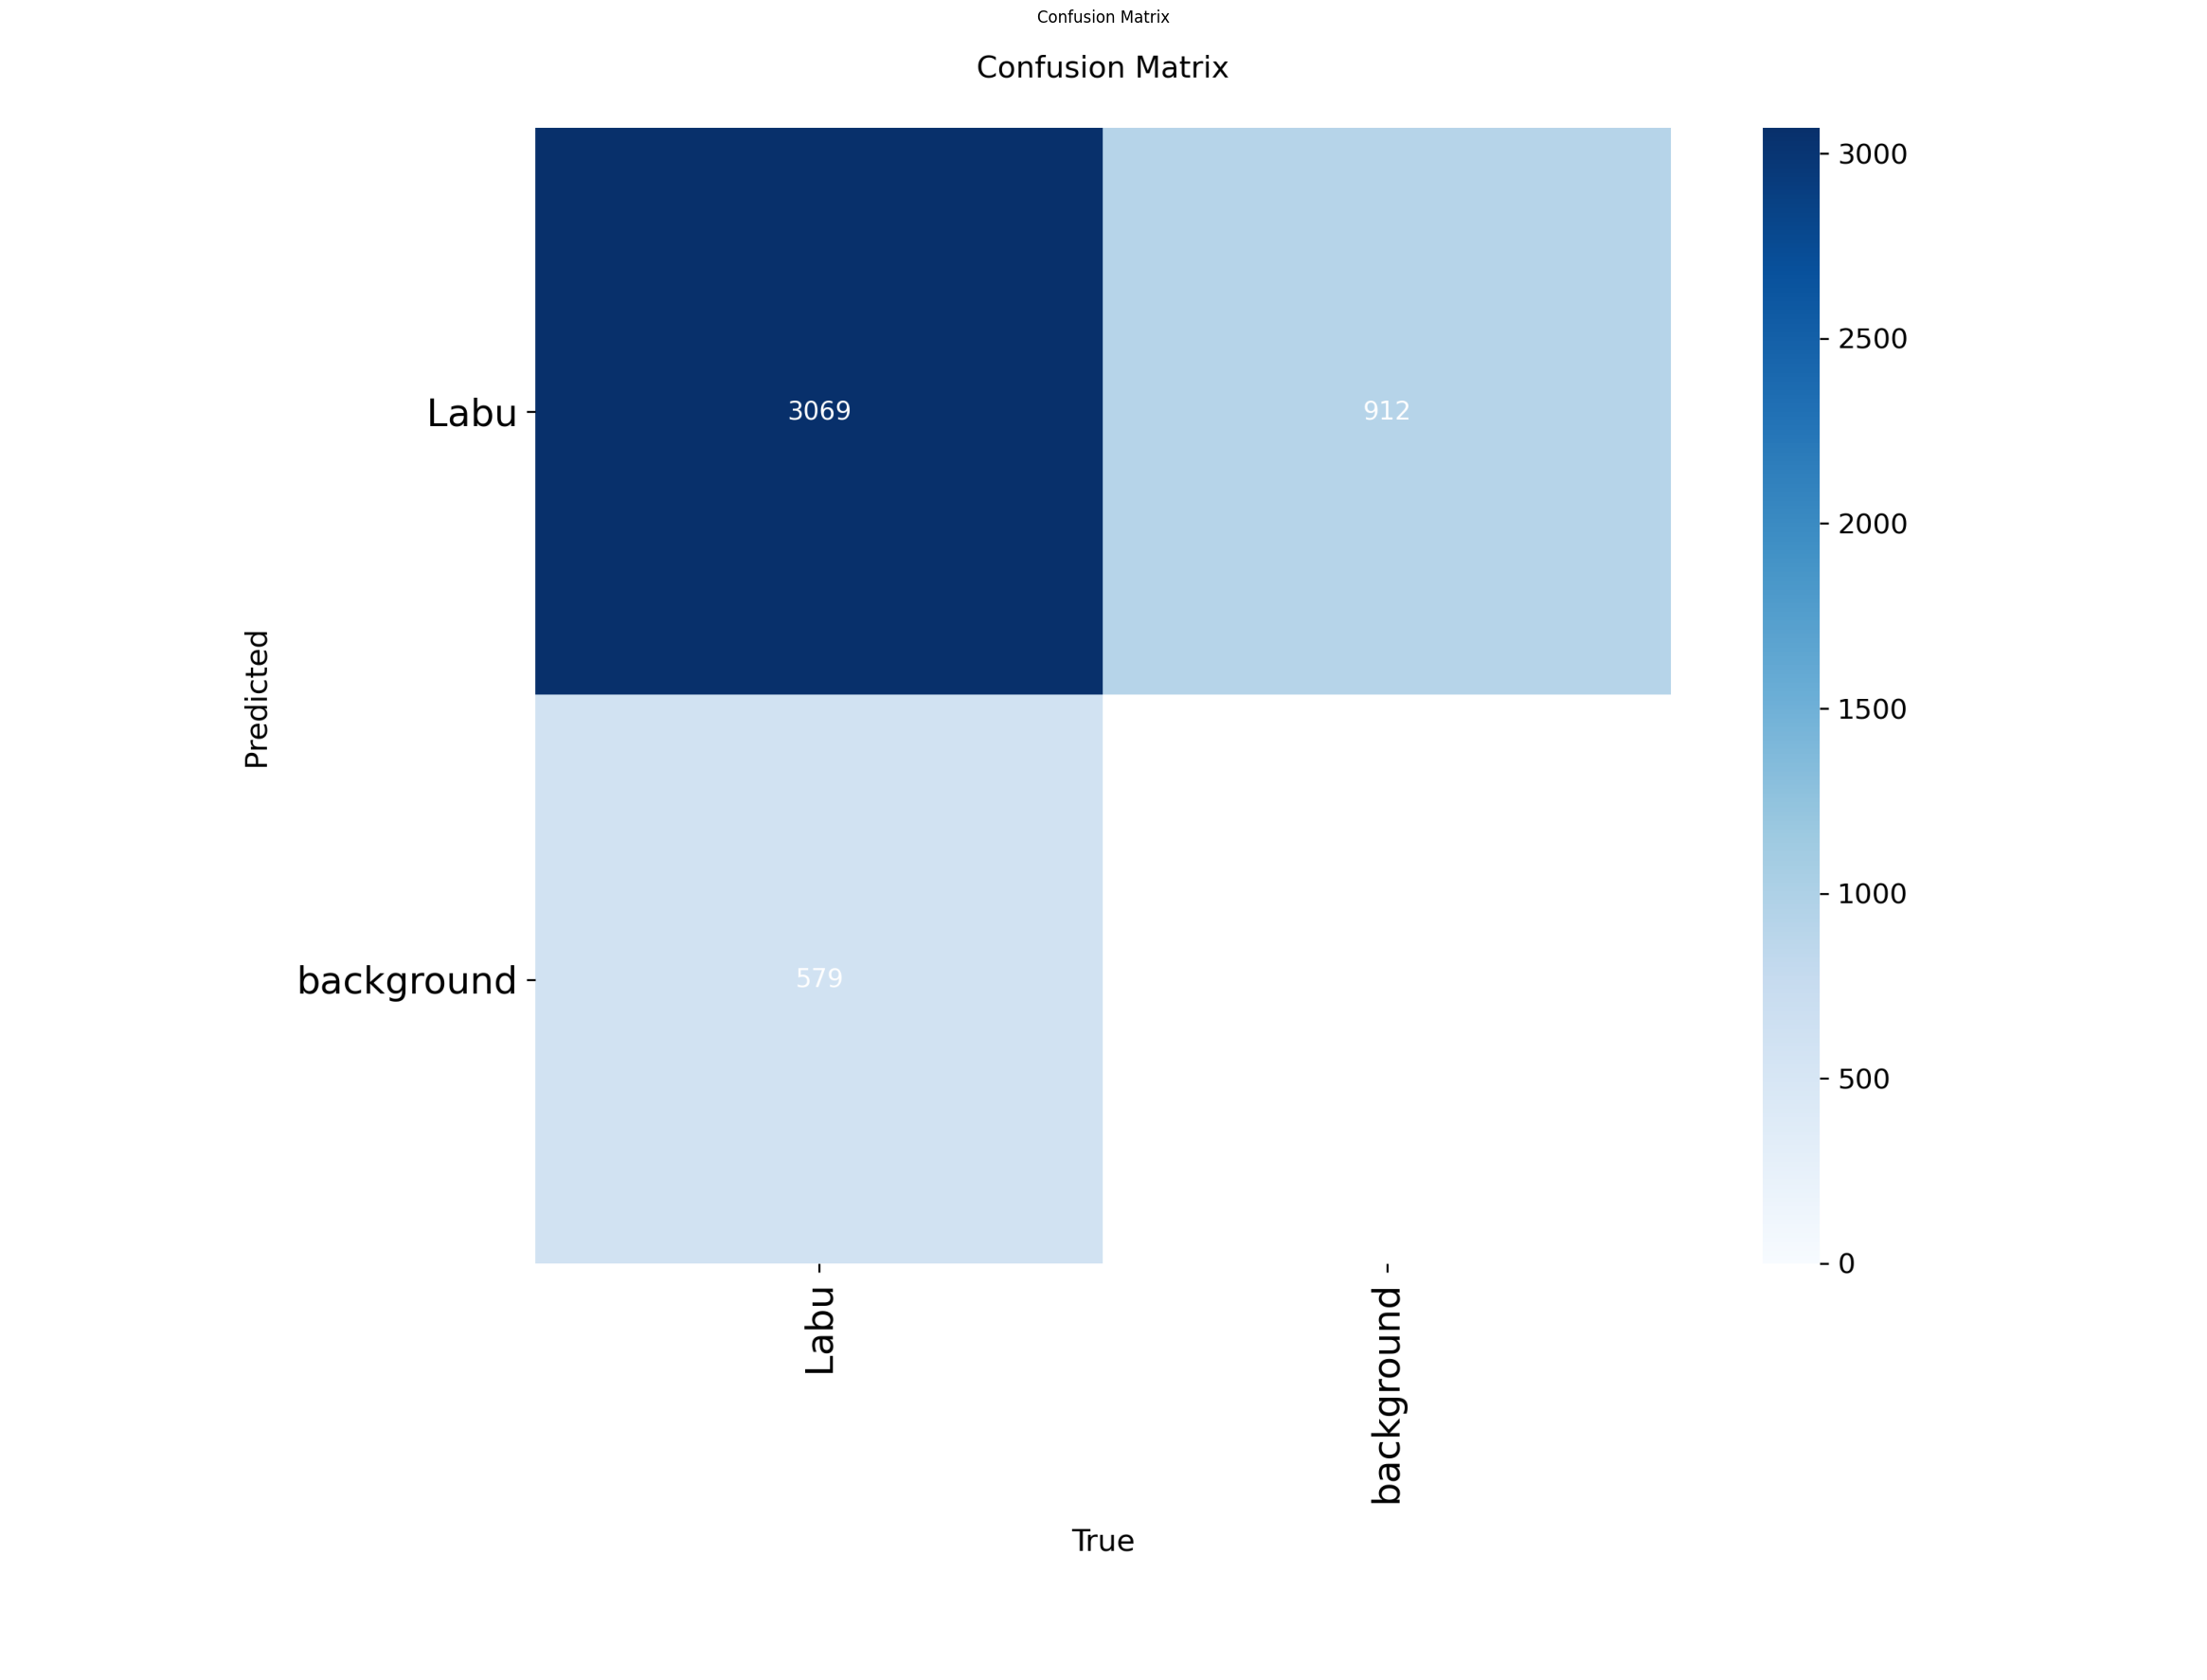

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/train/confusion_matrix.png"
img = Image.open(img_path)

w, h = img.size
dpi = 100

plt.figure(figsize=(w/dpi, h/dpi), dpi=dpi)
plt.imshow(img)
plt.axis('off')
plt.title("Confusion Matrix", fontsize=12)
plt.show()

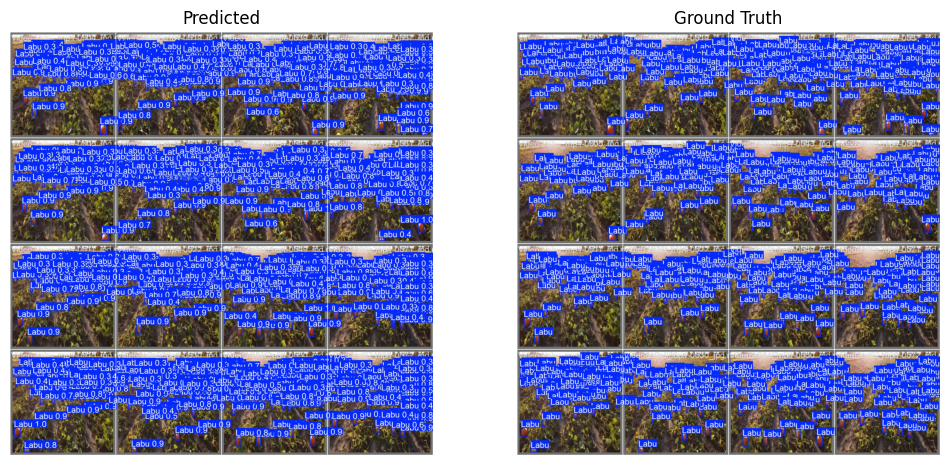

In [ ]:
pred = Image.open("runs/detect/train/val_batch0_pred.jpg")
labels = Image.open("runs/detect/train/val_batch0_labels.jpg")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(pred)
plt.axis('off')
plt.title("Predicted")

plt.subplot(1, 2, 2)
plt.imshow(labels)
plt.axis('off')
plt.title("Ground Truth")

plt.show()

In [ ]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import numpy as np
from datetime import datetime

In [ ]:
!pip install ultralytics opencv-python

In [ ]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import numpy as np
from datetime import datetime

# Fungsi bantu untuk cek apakah suatu titik sudah melewati garis (y-line)
def has_crossed_line(y_center, line_y, direction='down'):
    if direction == 'down':
        return y_center > line_y
    else:
        return y_center < line_y

# Load model YOLO yang sudah dilatih untuk deteksi labu
model = YOLO("runs/detect/train/weights/best.pt")  # Ganti path jika perlu

# Input-output video (bisa kamu tambah)
video_pairs = [
    ("Video Labu.mp4", "output_labu.mp4"),
]

# Loop untuk setiap video
for video_input, video_output in video_pairs:
    tracker = DeepSort(
        max_age=30,
        n_init=3,
        max_iou_distance=0.7,
        embedder="mobilenet",
        half=True,
        bgr=True
    )

    cap = cv2.VideoCapture(video_input)
    w, h, fps = int(cap.get(3)), int(cap.get(4)), cap.get(5)

    out = cv2.VideoWriter(video_output,
                          cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    # Garis hitung horizontal (di bawah, sekitar 70% dari tinggi frame)
    count_line_y = int(h * 0.7)
    crossed_ids = set()
    total_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, conf=0.4, iou=0.5, imgsz=1280)[0]
        detections = []

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            label = model.names[cls].lower()

            if label != "labu":  # pastikan label sesuai dengan model
                continue

            bbox = [x1, y1, x2 - x1, y2 - y1]
            detections.append((bbox, conf, "labu"))

        tracks = tracker.update_tracks(detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            l, t, r, b = track.to_ltrb()
            cx = int((l + r) / 2)
            cy = int((t + b) / 2)

            # Gambar bounding box
            # Hanya tampilkan bounding box jika labu berada dekat dengan garis (misal dalam 100px)
            if abs(cy - count_line_y) < 100:
              cv2.rectangle(frame, (int(l), int(t)), (int(r), int(b)), (0, 255, 0), 2)
              cv2.putText(frame, "Labu", (int(l), int(t) - 10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Hitung hanya sekali per ID jika sudah melewati garis
            if has_crossed_line(cy, count_line_y, direction='down') and track_id not in crossed_ids:
                crossed_ids.add(track_id)
                total_count += 1

        # Gambar garis horizontal
        cv2.line(frame, (0, count_line_y), (w, count_line_y), (0, 0, 255), 2)
        cv2.putText(frame, f"Jumlah Labu: {total_count}", (20, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

        # Timestamp
        # now = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        # cv2.putText(frame, now, (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
        #             (255, 255, 255), 2)


        out.write(frame)

    cap.release()
    out.release()



0: 736x1280 51 Labus, 16.4ms
Speed: 6.1ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 55 Labus, 12.2ms
Speed: 6.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 53 Labus, 12.3ms
Speed: 6.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 54 Labus, 12.3ms
Speed: 5.7ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 54 Labus, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 57 Labus, 11.6ms
Speed: 6.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 58 Labus, 10.6ms
Speed: 5.1ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 63 Labus, 10.7ms
Speed: 5.5ms preprocess, 10.7ms inference, 1.6ms postprocess per image at 